# Mod 4 Project


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
# Import python libraries.

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [8,3]

import folium

import geopandas as gpd

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


import itertools
import ast

In [2]:
# Importing data
folder_name = 'data/'

zillow_data = 'zillow_data.csv'
df = pd.read_csv(zillow_data, index_col = 0)

df['RegionID'] = df.index

columns = list(df.columns)
columns.insert(0, columns.pop())

df = df[columns]
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
RegionID,,,,,,,,,,,,,,,,,,,,,
84654,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
90668,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
91982,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
84616,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
93144,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Importing U.S. state shape files:

In [3]:
folder_name = 'shape_files/'
states = 'tl_2017_us_state'

state_map_data = gpd.read_file(folder_name + states + '/' + states + '.shp')

# Reduce size of dataframe to include only columns needed.
columns_to_keep = ['STUSPS', 'NAME', 'geometry']
state_map_data = state_map_data[columns_to_keep]
state_map_data.head()

,STUSPS,NAME,geometry
0,WV,West Virginia,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,FL,Florida,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ..."
2,IL,Illinois,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,MN,Minnesota,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,MD,Maryland,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


### Importing NYC zipcode shape files:

In [4]:
nys_folder = 'shape_files/NYC_ZIP_CODES/'

nyc_zip_codes = 'ZIP_CODE_040114.shp'

nyc_map_data = gpd.read_file(nys_folder + nyc_zip_codes)

# Reduce size of dataframe to include only columns needed.
columns_to_keep = ['ZIPCODE', 'COUNTY', 'geometry']
nyc_map_data = nyc_map_data[columns_to_keep]
nyc_map_data['ZIPCODE'] = nyc_map_data['ZIPCODE'].astype(int)

nyc_map_data.head()

,ZIPCODE,COUNTY,geometry
0,11436,Queens,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,Kings,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,Kings,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,Kings,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,Kings,"POLYGON ((991997.113 176307.496, 992042.798 17..."


### Importing NYC subway shape files:

In [5]:
###  Subway Lines ###

nyc_subway = 'shape_files/Subway Lines/'
nyc_subway_file = 'geo_export_408b948b-d084-4020-b609-1ad9aad058e6.shp'

mta_subway = gpd.read_file(nyc_subway + nyc_subway_file)

# Creating a dictionary of subway line colors, as denoted by the NYC MTA maps
line_colors = {
    '1': 'red',
    '4': 'green',
    '7': 'purple',
    'A': 'dodgerblue',
    'B': 'orange',
    'G': 'lightgreen',
    'J': 'brown',
    'L': 'grey',
    'N': 'yellow'
}

In [6]:
###  Subway Entrances ###
nyc_sub_ent = 'shape_files/Subway Entrances/'
nyc_sub_ent_file = 'geo_export_5b417b73-197e-4de2-8462-6efaf582e7d6.shp'
mta_entrances = gpd.read_file(nyc_sub_ent + nyc_sub_ent_file)

# converting the geometry shape file into columns with latitude and longitude.
mta_entrances['lat'] = mta_entrances['geometry'].x
mta_entrances['long'] = mta_entrances['geometry'].y

mta_entrances.head()

,line,name,objectid,url,geometry,lat,long
0,2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/,POINT (-73.86836 40.84917),-73.868356,40.849169
1,2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/,POINT (-73.86821 40.84913),-73.868213,40.849128
2,2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/,POINT (-73.87350 40.84122),-73.873499,40.841223
3,2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/,POINT (-73.87289 40.84145),-73.872892,40.841453
4,2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/,POINT (-73.87962 40.84082),-73.879623,40.840815


# Step 2: Data Preprocessing

In [7]:
# Converting the column dates from string to datetime

def get_datetimes(df, head_columns):
    df.columns.values[head_columns:] = pd.to_datetime(df.columns.values[head_columns:], format='%Y-%m')
    
get_datetimes(df, 7)

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
RegionID,,,,,,,,,,,,,,,,,,,,,
84654,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
90668,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
91982,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
84616,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
93144,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 3: Reshape from Wide to Long Format

In [8]:
def melt_data(df):
    
    '''
    This function will be used to convert the dataframe from the wide format to the long format
    '''   
    
    melted = pd.melt(df, id_vars=
                     ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [9]:
def percent_growth(dataframe):
    '''
    This function will calculate the percent growth of a dataframe between 
    the first and last index of that dataframe
    '''
    
    pct_growth = {}
    for column in dataframe.columns:
        pct_growth[column] = (dataframe[column][-1] - dataframe[column][0]) / dataframe[column][0]
    
    return pct_growth

### Analysis on state basis:

The melt_data fucntion is called across all the states to calculate the mean values of each state across the given time series index.

In [10]:
dataframe = {}

for state in set(df['State']):
    dataframe[state] = melt_data(df[df['State'] == state])['value']
    
states_df = pd.DataFrame(dataframe)

states_df.bfill(axis = 'rows', inplace = True)

states_df.head()

,WY,OR,FL,NC,CA,WV,MO,MN,UT,VA,...,NY,MS,WI,MA,TX,PA,SC,IL,MT,ND
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,138712.500000,124325.714286,104529.019608,91146.019900,200220.959596,66461.666667,91146.468401,90961.918605,159645.689655,122071.236559,...,129927.512690,86397.014925,115151.376147,159684.541063,109384.639831,89103.011292,82504.687500,127624.665392,157838.461538,132576.923077
1996-05-01,138762.500000,124852.380952,104594.117647,91397.512438,200124.831650,66575.000000,91395.910781,91142.732558,159523.275862,122136.827957,...,129850.558376,86532.835821,115099.388379,160031.642512,109406.885593,89175.784191,82895.312500,127884.703633,157840.384615,132576.923077
1996-06-01,138741.666667,125366.190476,104662.352941,91621.890547,200035.942761,66708.333333,91664.684015,91332.267442,159406.896552,122201.075269,...,129776.142132,86670.149254,115032.110092,160384.782609,109451.377119,89243.789210,83322.395833,128043.021033,157871.153846,132576.923077
1996-07-01,138641.666667,125877.142857,104727.058824,91837.810945,199965.572391,66848.333333,91946.840149,91510.465116,159313.793103,122267.204301,...,129694.213198,86792.537313,114940.672783,160742.995169,109521.504237,89302.258469,83784.375000,128086.615679,157928.846154,132576.923077
1996-08-01,138533.333333,126403.809524,104816.993464,92063.930348,199958.754209,67016.666667,92252.044610,91693.313953,159254.310345,122352.419355,...,129623.350254,86914.925373,114840.978593,161103.140097,109613.983051,89368.883312,84286.458333,128025.621415,157982.692308,132576.923077


# Step 4: EDA and Visualization

## State Analysis

In [11]:
def us_map(map_data, dataframe):
    
    '''
    This fucntion takes two arguments; map_data and dataframe.
    map_data - is the dataframe containing the shape files for the given map
    dataframe - the dataframe used to map the choropleth to the shapefiles
    '''
    map_data['data'] = 0
    
    # The dataframe data will be used to map to map_data dataframe column 'data'
    # where the weights are stored for the color maping
    
    map_data['data'] = map_data['STUSPS'].map(dataframe)
    
    # map build
    mymap = folium.Map(location=[50, -110], zoom_start= 3.2, tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)
    myscale = (map_data['data'].quantile((0,0.25,0.5, 0.9,1))).tolist()

    mymap.choropleth(
         geo_data=map_data,
         name='Choropleth',
         data=map_data,
         columns=[map_data.columns[1],map_data.columns[-1]],
         key_on= str("feature.properties." + map_data.columns[1]),
         fill_color='RdYlGn',
         threshold_scale=myscale,
         fill_opacity=0.8,
         line_opacity=0.2,
         legend_name='percent growth',
         smooth_factor=0
        )
    
    return mymap

### Calculating the percent change for each state from 1996 to 2018

In [12]:
# us_map(state_map_data, percent_growth(states_df))

### Calculating the percent change for each state from 2013 to 2018 - Last 5 years

In [13]:
# us_map(state_map_data, percent_growth(states_df[states_df.index > '2012-12-01']))

### Calculating the percent change for each state from 2017 to 2018 - Last year

In [14]:
# us_map(state_map_data, percent_growth(states_df[states_df.index > '2016-12-01']))

## Targeting NYC as the area to invest in

### Analysis on a NYC borogh basis:

The melt_data fucntion is called across all the boroughs of NYC to calculate the mean values of each state across the given time series index.

In [15]:
dataframe = {}

for borough in set(df[df['City'] == 'New York']['CountyName']):
    dataframe[borough] = melt_data(df[df['CountyName'] == borough])['value']
    
borough_df = pd.DataFrame(dataframe)

borough_df.head()

,New York,Queens,Bronx,Kings,Richmond
time,,,,,
1996-04-01,1920650.0,187170.370370,179727.272727,163931.034483,166991.666667
1996-05-01,1934750.0,187407.407407,180009.090909,164017.241379,166616.666667
1996-06-01,1947750.0,187785.185185,180254.545455,164103.448276,166266.666667
1996-07-01,1960650.0,188238.888889,180354.545455,164217.241379,165891.666667
1996-08-01,1974600.0,188712.962963,180372.727273,164403.448276,165550.000000


Plotting the data to inspect any trends / identiy areas of interes:

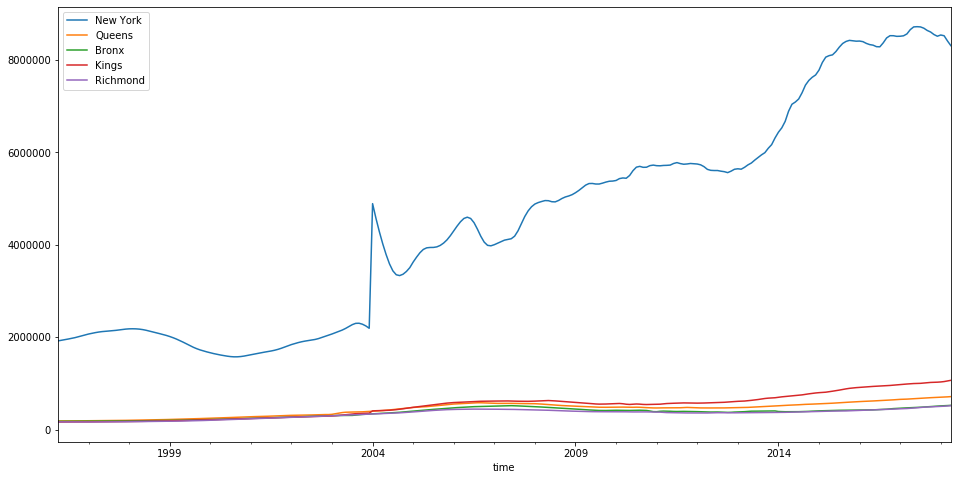

In [16]:
borough_df.plot(figsize=(16,8))

Removing borough 'Manhattan' from the plot due to out of budget and overly competitive market

Text(0, 0.5, 'Property value, USD')

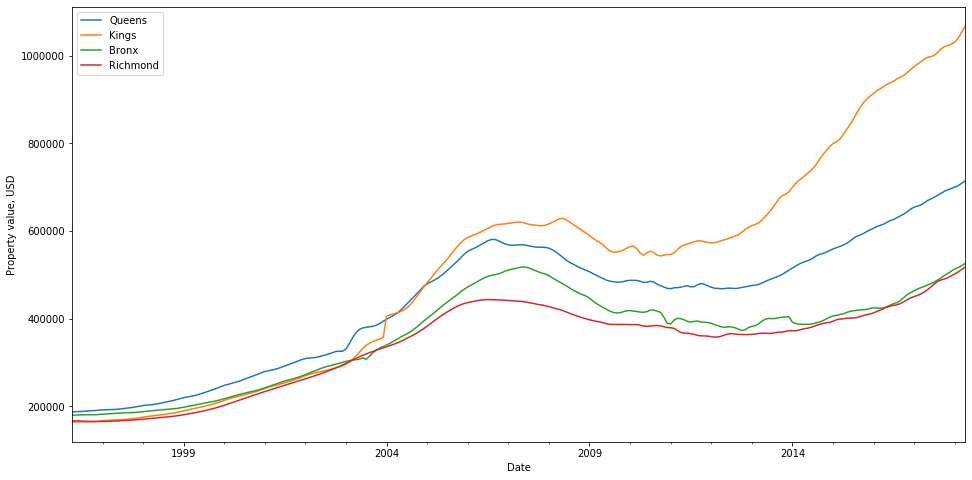

In [17]:
ax = borough_df[['Queens', 'Kings', 'Bronx', 'Richmond']].plot(figsize=(16,8))

ax.set_xlabel('Date')
ax.set_ylabel('Property value, USD')

In [18]:
def nyc_map(map_data, dataframe, target, target_index, subway_lines, subway_entrances):
    
    '''
    This fucntion takes two arguments; map_data and dataframe.
    map_data - is the dataframe containing the shape files for the given map
    dataframe - the dataframe used to map the choropleth to the shapefiles
    target - 'COUNTY' or 'ZIPCODE'
    target_index - if target = 'COUNTY' then 0, if 'ZIPCODE' then 1.
    subway_lines - Set to TRUE/FALSE for visibility
    subway_entrances - Set to TRUE/FALSE for visibility
    
    '''
    
    global mta_entrances, mta_subway

    map_data['data'] = 0
    
    # The dataframe data will be used to map to map_data dataframe column 'data'
    # where the weights are stored for the color maping
    
    map_data['data'] = map_data[target].map(dataframe)
    map_data.dropna(inplace = True)
        
    # map build
    mymap = folium.Map(location=[40.7128,-73.9352], zoom_start=10.25, tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(mymap)

    myscale = (map_data['data'].quantile((0,0.25,0.5, 0.9,1))).tolist()

    mymap.choropleth(
         geo_data=map_data,
         name='Choropleth',
         data=map_data,
         columns=[map_data.columns[target_index],map_data.columns[-1]],
         key_on= str("feature.properties." + map_data.columns[target_index]),
         fill_color='Reds',
         threshold_scale=myscale,
         fill_opacity=0.8,
         line_opacity=0.2,
         legend_name='percent growth',
         smooth_factor=0
        )
    
    if subway_lines:
        for line in set(mta_subway['rt_symbol']):
            folium.Choropleth(
            mta_subway[mta_subway['rt_symbol'] == line]['geometry'],
            line_weight=2,
            line_color=line_colors[line]
        ).add_to(mymap)

    if subway_entrances:
        for entrance in range(len(mta_entrances)):
            folium.CircleMarker(
                location=[mta_entrances['long'][entrance],mta_entrances['lat'][entrance]],
                radius=3,
                color="black",
                fill=True,
                fill_color="black",
            ).add_to(mymap)

    return mymap

In [19]:
# nyc_map(nyc_map_data, 
#         percent_growth(borough_df), 
#         'COUNTY', 1, False, False)

### By zipcode

In [20]:
dataframe = {}

for zipcode in set(df[df['City'] == 'New York']['RegionName']):
    dataframe[zipcode] = melt_data(df[df['RegionName'] == zipcode])['value']
    
nyc_zipcode_df = pd.DataFrame(dataframe)
nyc_zipcode_df.bfill(axis = 'rows', inplace = True)

nyc_zipcode_df.head()

,10301,10302,10303,10304,10305,10306,10307,10308,10309,10310,...,11226,11228,11229,11230,11231,11233,11234,11235,11236,11238
time,,,,,,,,,,,,,,,,,,,,,
1996-04-01,175800.0,135900.0,129800.0,157500.0,159200.0,178300.0,186700.0,176100.0,192600.0,155600.0,...,162000.0,219300.0,183900.0,230100.0,969500.0,124500.0,172300.0,190500.0,160900.0,671200.0
1996-05-01,175500.0,135600.0,129400.0,157000.0,158900.0,177600.0,186800.0,175400.0,192500.0,155600.0,...,162300.0,219600.0,184200.0,230800.0,969500.0,124500.0,172100.0,191000.0,161000.0,671200.0
1996-06-01,175200.0,135400.0,129000.0,156500.0,158600.0,176800.0,186900.0,174800.0,192600.0,155600.0,...,162600.0,219900.0,184500.0,231500.0,969500.0,124500.0,171900.0,191500.0,161200.0,671200.0
1996-07-01,174900.0,135000.0,128600.0,156000.0,158300.0,176100.0,187100.0,174200.0,192600.0,155600.0,...,163000.0,220200.0,184800.0,232100.0,969500.0,124500.0,171600.0,192000.0,161300.0,671200.0
1996-08-01,174600.0,134700.0,128200.0,155500.0,158000.0,175300.0,187400.0,173600.0,192800.0,155500.0,...,163400.0,220600.0,185000.0,232800.0,969500.0,124700.0,171400.0,192500.0,161500.0,671200.0


### Calculating the percent change for each nyc zipcode from 1996 to 2018

In [21]:
# nyc_map(nyc_map_data, 
#         percent_growth(nyc_zipcode_df), 
#         'ZIPCODE', 0, False, False)

### Calculating the percent change for each zipcode from 2013 to 2018 - Last 5 years

In [22]:
# nyc_map(nyc_map_data, 
#         percent_growth(nyc_zipcode_df[nyc_zipcode_df.index > '2012-12-01']), 
#         'ZIPCODE', 0, False, False)

### Calculating the percent change for each zipcode from 2017 to 2018 - Last year

In [23]:
# nyc_map(nyc_map_data, 
#         percent_growth(nyc_zipcode_df[nyc_zipcode_df.index > '2016-12-01']), 
#         'ZIPCODE', 0, False, False)

In [24]:
target_zips = [11385, 11379, 11377, 11373, 11372]
model_df = nyc_zipcode_df[target_zips]
model_df.head()

,11385,11379,11377,11373,11372
time,,,,,
1996-04-01,160600.0,192200.0,179000.0,175400.0,190200.0
1996-05-01,160900.0,192800.0,178900.0,175800.0,190800.0
1996-06-01,161300.0,193600.0,179000.0,176400.0,191700.0
1996-07-01,161800.0,194400.0,179000.0,177000.0,192600.0
1996-08-01,162300.0,195200.0,179100.0,177600.0,193500.0


In [25]:
# nyc_map(nyc_map_data, 
#         percent_growth(model_df[model_df.index > '2016-12-01']), 
#         'ZIPCODE', 0, True, True)

### Exploring the timeseries data as visuals

For the time series analysis, the mean across the 5 targeted zipcodes will be used.

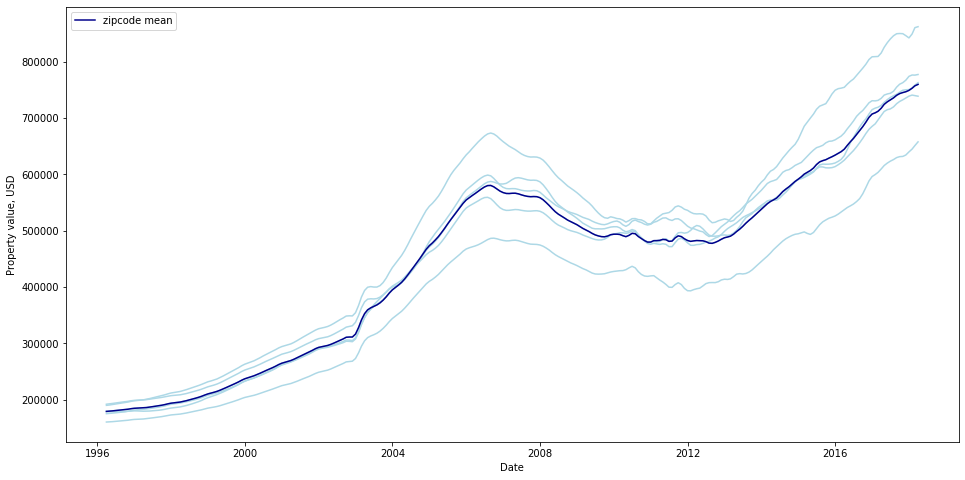

In [26]:
fig, ax = plt.subplots(figsize=(16,8))

model_df['mean'] = model_df.mean(axis = 1)

plt.plot(model_df, color = 'lightblue')
plt.plot(model_df[model_df.columns[-1]], color = 'darkblue', label = 'zipcode mean')
plt.legend(loc = 'best')

ax.set_xlabel('Date')
ax.set_ylabel('Property value, USD')
plt.legend()

# Step 5: ARIMA Modeling

In [27]:
def get_stationarity(timeseries):
    
    '''
    Input the dataframe of the timeseries.
    The output will be a plot of the Rolling Mean & Rolling Standard Deviation.
    The Dickey-Filler test will be performed on the data, with a print out of the test results.
    '''
        
    rolling_mean = timeseries.rolling(window = 8).mean()
    rolling_std = timeseries.rolling(window = 8).std()

    plt.subplots(figsize=(14,6))
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()
    
    result = adfuller(timeseries)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values' % result[0])

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if result[0] < result[4]["5%"]:
        print("Reject Ho - Time Series is Stationary")
    else:
        print("Failed to Reject Ho - Time Series is Non-Stationary")

## Checking data for stationarity
### Original timeseries data

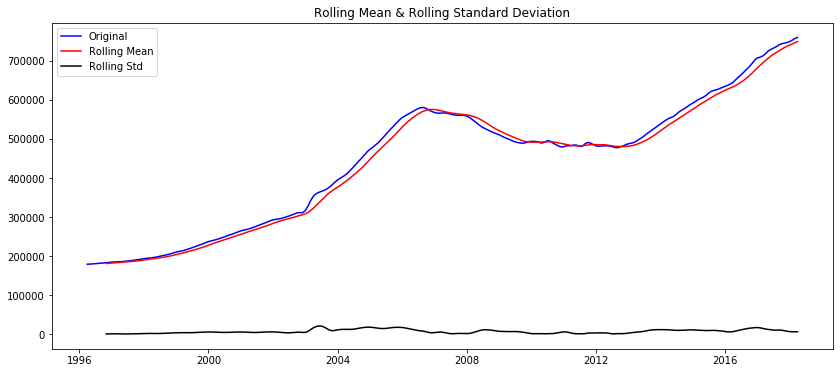

ADF Statistic: -1.291931
p-value: 0.632856
Critical Values
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject Ho - Time Series is Non-Stationary


In [28]:
get_stationarity(model_df['mean'])

### Difference - 1x

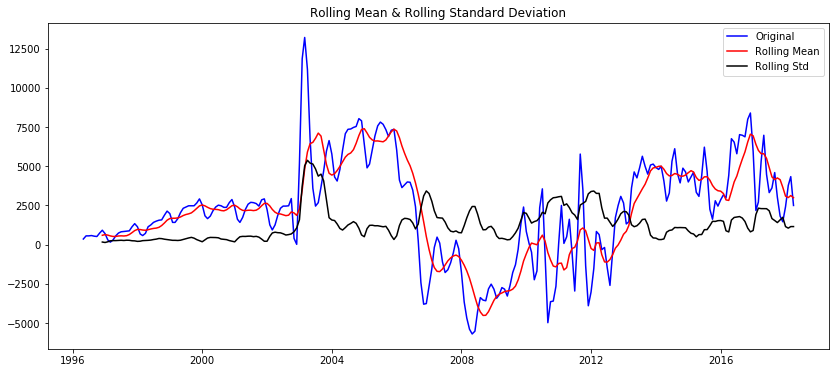

ADF Statistic: -1.841408
p-value: 0.360106
Critical Values
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject Ho - Time Series is Non-Stationary


In [29]:
data_diff_1 = model_df['mean'].diff().dropna()
get_stationarity(data_diff_1)

### Difference - 2x

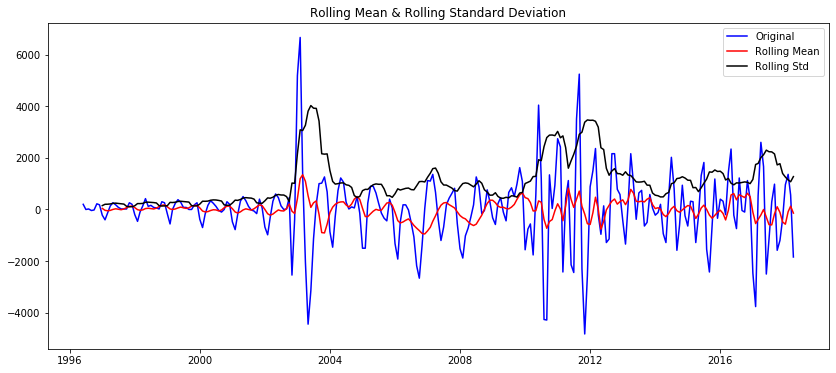

ADF Statistic: -6.136675
p-value: 0.000000
Critical Values
	1%: -3.457
	5%: -2.873
	10%: -2.573
Reject Ho - Time Series is Stationary


In [30]:
data_diff_2 = model_df['mean'].diff().diff().dropna()
get_stationarity(data_diff_2)

### Parameter selection for the ARIMA model

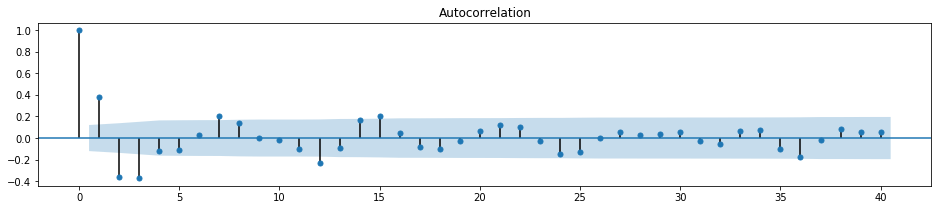

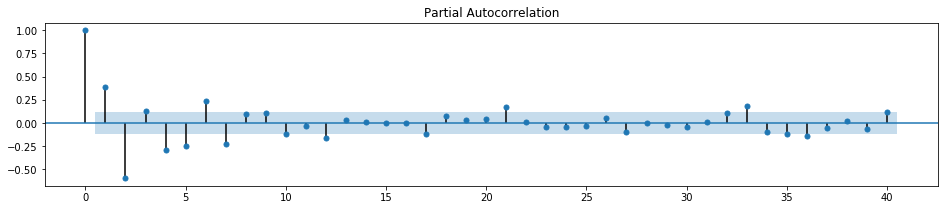

In [31]:
# Autocorrelation function
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(data_diff_2, ax=ax, lags=40);

# Partial Autocorrelation function
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(data_diff_2, ax=ax, lags=40);

In [32]:
# The order of the model can be ontained by inspection of the plots above, for a 2x difference (d = 2). 
# The autocorrelation fucntion is used to determine p, from the trends the first value within the tollerance is 4. 
# The partial autocorrelation fucntion is used to determine q, from the trends the first value within the tollerance is 3. 

# There is no seasonality and therefore we set those terms to 0.
seasonal_pdq = [0,0,0,0]
mod = sm.tsa.statespace.SARIMAX(model_df[model_df.index > pd.to_datetime('2002-01-01')]['mean'],
                                            order=(4,2,3),
                                            seasonal_order=seasonal_pdq,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

results = mod.fit()

# Step 6: Interpreting Results

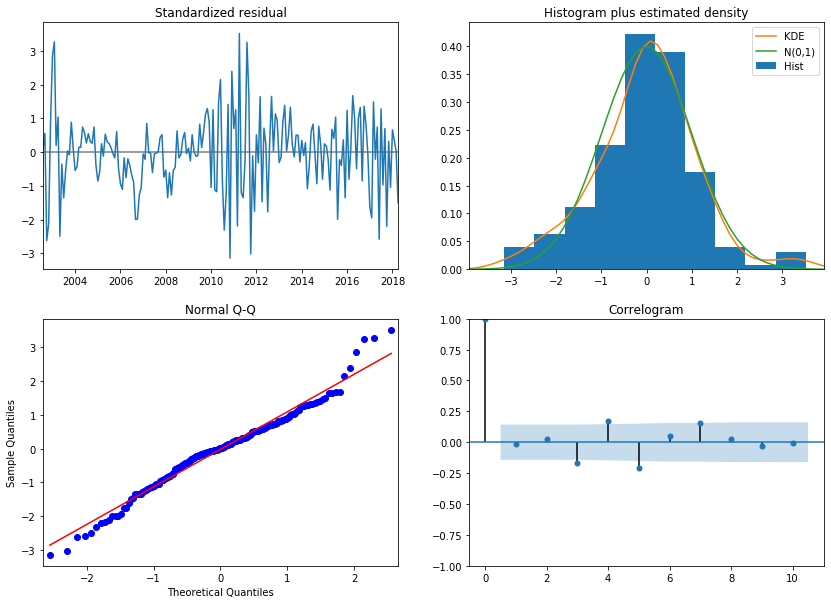

In [33]:
results.plot_diagnostics(figsize=(14, 10))
plt.show()

### Validating the forecasts

Using 'get_prediction' to evaluate the performance of our model

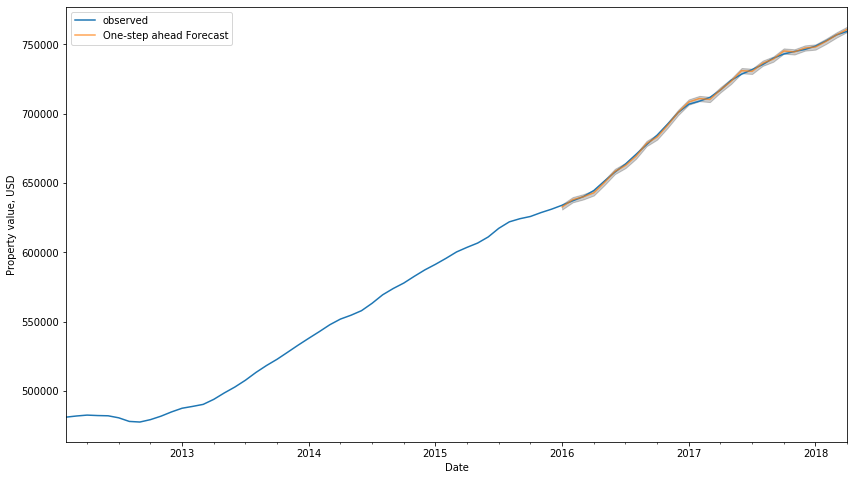

In [34]:
pred_start = pd.to_datetime('2016-01-01')
pred = results.get_prediction(start=pred_start, dynamic=False)
pred_ci = pred.conf_int()

ax = model_df[model_df.index > pd.to_datetime('2012-01-01')]['mean'].plot(label='observed', figsize=(14, 8))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Property value, USD')
plt.legend()

plt.show()

The MSE (Mean Squared Error), summarized the average error of our forecast

In [35]:
y_forecasted = pred.predicted_mean
y_truth = model_df[model_df.index >= pred_start]['mean']

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1373693.51


Plotting the observed and dynamic forecast values of the time series.

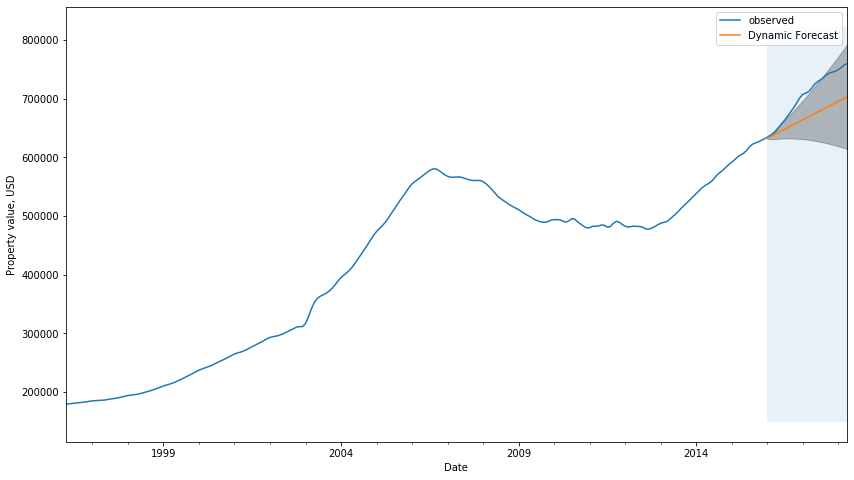

In [36]:
pred_dynamic = results.get_prediction(start=pred_start, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int(alpha = 0.2)

ax = model_df['mean'].plot(label='observed', figsize=(14, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pred_start, model_df.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Property value, USD')

plt.legend(loc = 'best')
plt.show()

Forecasting future values, leveraging 'get_forecast()'

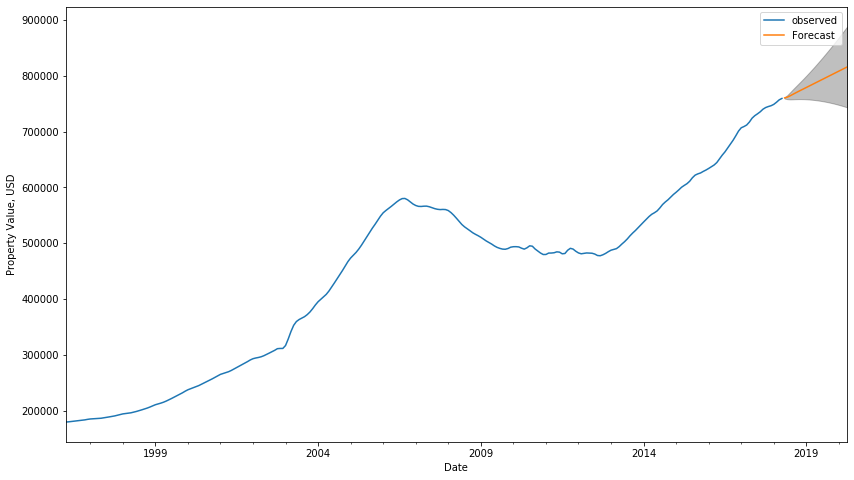

In [37]:
# Get forecast 24 steps ahead in future
pred_uc = results.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha = 0.2)

ax = model_df['mean'].plot(label='observed', figsize=(14, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Property Value, USD')

plt.legend(loc = 'best')
plt.show()